In [2]:
import wetter_api as wt
import waldbrand
import model_eval as me
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error, r2_score
import logging
import pandas as pd
import common_paths
import seaborn as sb
import plotly.express as pl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [3]:
parameter_list = [
    wt.DwdObservationParameter.MONTHLY.PRECIPITATION_HEIGHT,
    wt.DwdObservationParameter.MONTHLY.CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT,
    wt.DwdObservationParameter.MONTHLY.TEMPERATURE_AIR_MAX_200,
]
# Dictionary with short names as keys and full names as values
shortname_to_state = {
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "BE": "Berlin",
    "BB": "Brandenburg",
    "HB": "Bremen",
    "HH": "Hamburg",
    "HE": "Hessen",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "SH": "Schleswig-Holstein",
    "TH": "Thüringen",
}

# Example usage
shortname = "BB"
state = shortname_to_state.get(shortname)

In [4]:
#nr = me.prepare_data(parameter_list, state, "nr")
data = me.prepare_data(parameter_list, state)
data

Year  Month station_id    pr   sfcWind  tasmax  nFires area
21    1996      1      00164   0.2  3.384206  275.15     1.0  0.0
22    1996      1      00427   0.7  3.729582  277.45     1.0  0.0
23    1996      1      00650   1.0  2.276450  277.65     1.0  0.0
24    1996      1      00880   2.8  2.746595  280.65     1.0  0.0
25    1996      1      01001   1.4  3.770945  281.15     1.0  0.0
...    ...    ...        ...   ...       ...     ...     ...  ...
8370  2022     12      03158  37.2  2.897073  290.65     0.0  0.0
8371  2022     12      03376  40.7  2.897073  290.65     0.0  0.0
8373  2022     12      03987  58.8  4.409306  290.45     0.0  0.0
8377  2022     12      05825  45.4  2.897073  289.95     0.0  0.0
8380  2022     12      07389  40.7  2.840331  290.05     0.0  0.0

[6390 rows x 8 columns]

In [18]:
future_bb_weather = pd.read_csv(common_paths.DATA.joinpath("dwd/future_Brandenburg.csv"))
future_bb_weather.drop(columns=['Unnamed: 0', 'Bundesland'], inplace = True)
#adjust precipitation to same unit
future_bb_weather['pr'] = future_bb_weather['pr'] * 3600 * 24 * 30
future_bb_weather

pr     tasmax   sfcWind  Year  Month
0      51.580644  278.43063  4.900000  2024      1
1      54.774196  278.38547  4.761291  2024      1
2      63.967742  278.19840  4.422581  2024      1
3      47.709679  278.55966  4.416129  2024      1
4      47.709679  278.54030  4.367742  2024      1
...          ...        ...       ...   ...    ...
70390  41.612901  274.10160  4.516129  2054      1
70391  51.967742  273.57257  5.196774  2054      1
70392  51.967742  273.62740  5.316129  2054      1
70393  45.483872  273.60483  5.216129  2054      1
70394  47.419354  273.66290  5.241936  2054      1

[70395 rows x 5 columns]

In [ ]:
#future_bb_weather = me.grid_means(future_brandenburg_weather)

In [19]:
print('means: \n' , data[['pr', 'sfcWind', 'tasmax']].mean())
print('\n variance: \n', data[['pr', 'sfcWind', 'tasmax']].var())
print('\n std: \n' , data[['pr', 'sfcWind', 'tasmax']].std())
print('\n min: \n', data[['pr', 'sfcWind', 'tasmax']].min())
print('\n max: \n', data[['pr', 'sfcWind', 'tasmax']].max())

means: 
 pr          46.103521
sfcWind      3.232686
tasmax     295.061628
dtype: float64

 variance: 
 pr         937.859930
sfcWind      0.828219
tasmax      75.838905
dtype: float64

 std: 
 pr         30.624499
sfcWind     0.910065
tasmax      8.708554
dtype: float64

 min: 
 pr           0.000000
sfcWind      0.510746
tasmax     274.250000
dtype: float64

 max: 
 pr         266.200000
sfcWind      7.768545
tasmax     312.350000
dtype: float64


In [219]:
print('means: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].mean())
print('\n variance: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].var())
print('\n std: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].std())
print('\n min: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].min())
print('\n max: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].max())

means: 
 pr          47.990091
sfcWind      3.670293
tasmax     287.263343
dtype: float64

 variance: 
 pr         738.434263
sfcWind      0.429837
tasmax      64.163249
dtype: float64

 std: 
 pr         27.174147
sfcWind     0.655619
tasmax      8.010197
dtype: float64

 min: 
 pr           0.387097
sfcWind      1.916129
tasmax     270.556460
dtype: float64

 max: 
 pr         257.599984
sfcWind      7.396774
tasmax     302.598400
dtype: float64


In [261]:
merged

Year  Month station_id    pr   sfcWind  tasmax area  nFires
0     1996      1      00164   0.2  3.384206  275.15  0.0     1.0
1     1996      1      00427   0.7  3.729582  277.45  0.0     1.0
2     1996      1      00650   1.0  2.276450  277.65  0.0     1.0
3     1996      1      00880   2.8  2.746595  280.65  0.0     1.0
4     1996      1      01001   1.4  3.770945  281.15  0.0     1.0
...    ...    ...        ...   ...       ...     ...  ...     ...
6385  2022     12      03158  37.2  2.897073  290.65  0.0     0.0
6386  2022     12      03376  40.7  2.897073  290.65  0.0     0.0
6387  2022     12      03987  58.8  4.409306  290.45  0.0     0.0
6388  2022     12      05825  45.4  2.897073  289.95  0.0     0.0
6389  2022     12      07389  40.7  2.840331  290.05  0.0     0.0

[6390 rows x 8 columns]

In [246]:
merged.dropna(inplace = True)

In [248]:
merged['Year'].count()

6390

<Axes: >

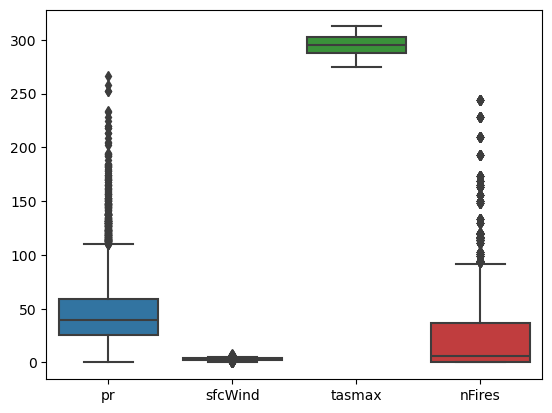

In [262]:
sb.boxplot(merged[['pr', 'sfcWind', 'tasmax', 'area', 'nFires']])

<Axes: >

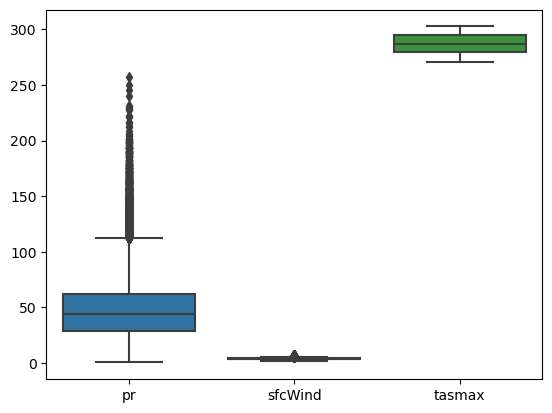

In [222]:
sb.boxplot(future_bb_weather[['pr', 'sfcWind', 'tasmax']])

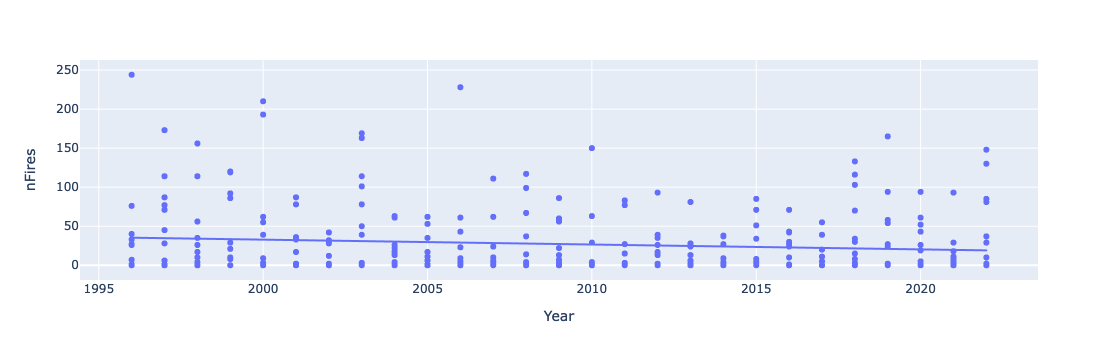

In [275]:
fig1 = pl.scatter(merged, x='Year', y='area', trendline="ols")
fig2 = pl.scatter(merged, x='Year', y='nFires', trendline="ols")
fig1.show()
fig2.show()

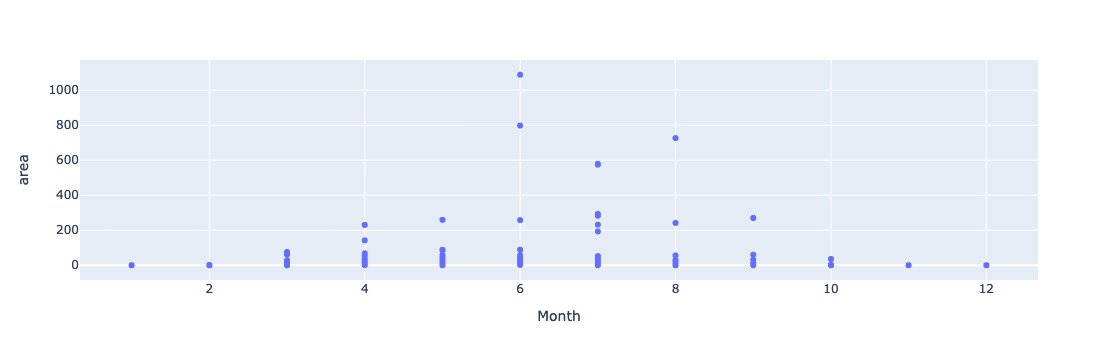

In [77]:
fig1 = pl.scatter(merged, x='Month', y='area')
fig2 = pl.scatter(merged, x='Month', y='nFires')
fig1.show()
fig2.show()

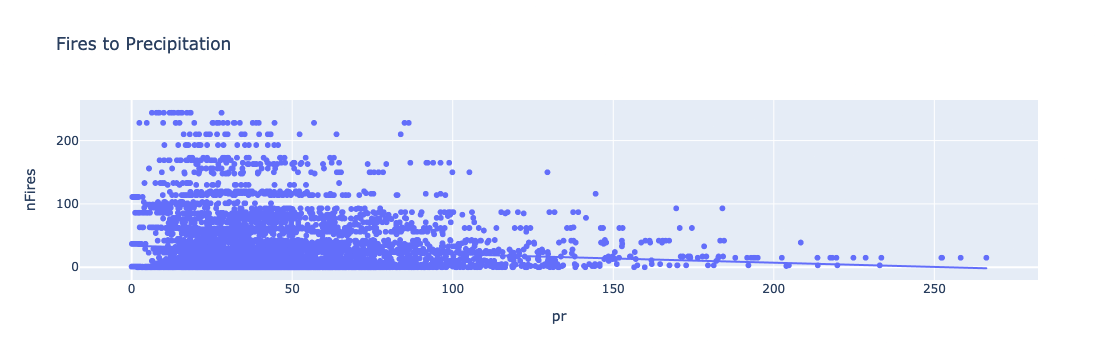

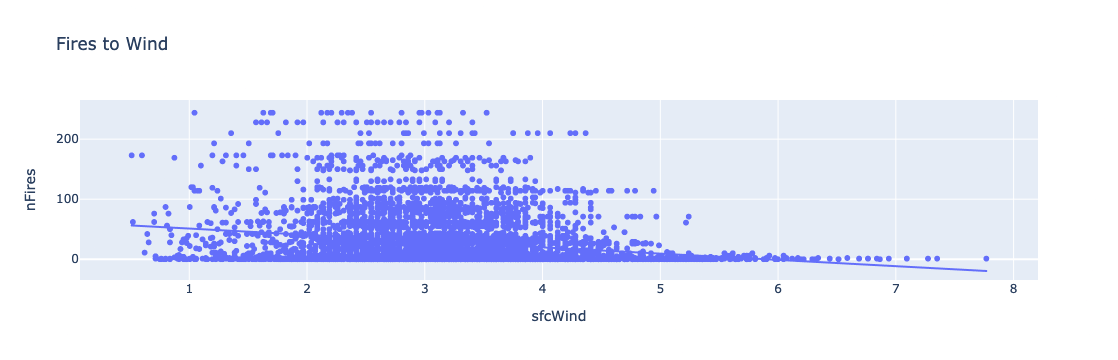

In [147]:
fig1 = pl.scatter(merged, x = "pr", y = 'nFires', trendline="ols", title='Fires to Precipitation')
fig2 = pl.scatter(merged, x = "sfcWind", y = 'nFires', trendline="ols", title='Fires to Wind')
fig3 = pl.scatter(merged, x = "tasmax", y = 'nFires', trendline="ols", title='Fires to Temperature')

fig1.show()
fig2.show()
fig3.show()

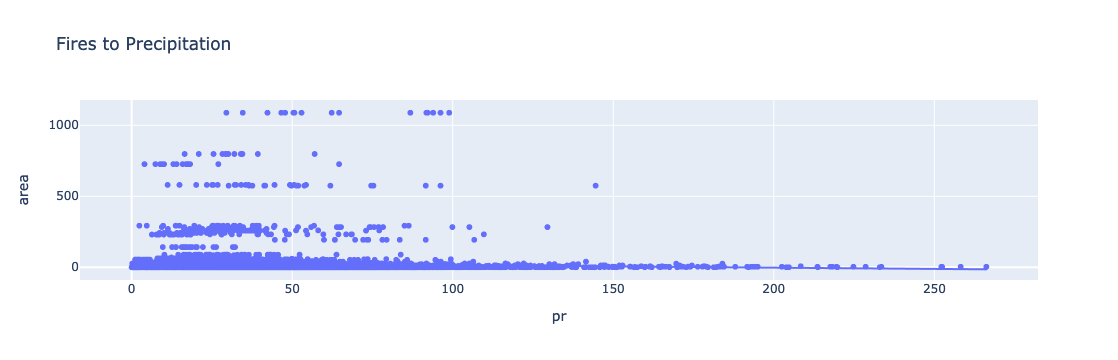

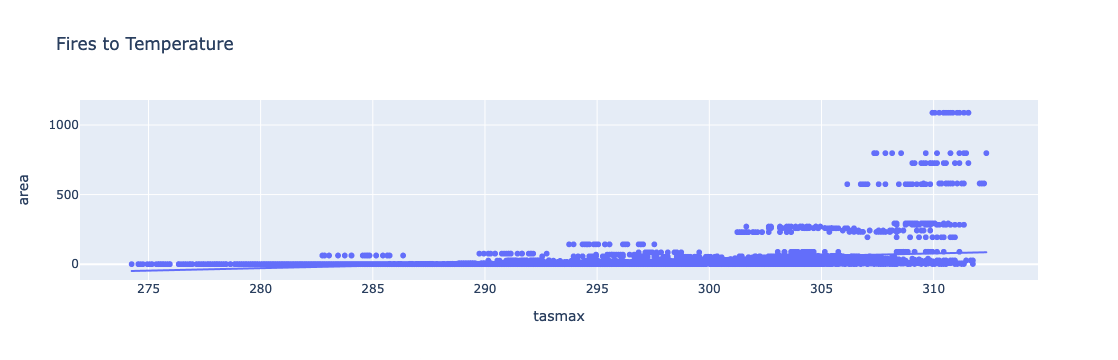

In [148]:
fig1 = pl.scatter(merged, x = "pr", y = 'area', trendline="ols", title='Fires to Precipitation')
fig2 = pl.scatter(merged, x = "sfcWind", y = 'area', trendline="ols", title='Fires to Wind')
fig3 = pl.scatter(merged, x = "tasmax", y = 'area', trendline="ols", title='Fires to Temperature')

fig1.show()
fig2.show()
fig3.show()

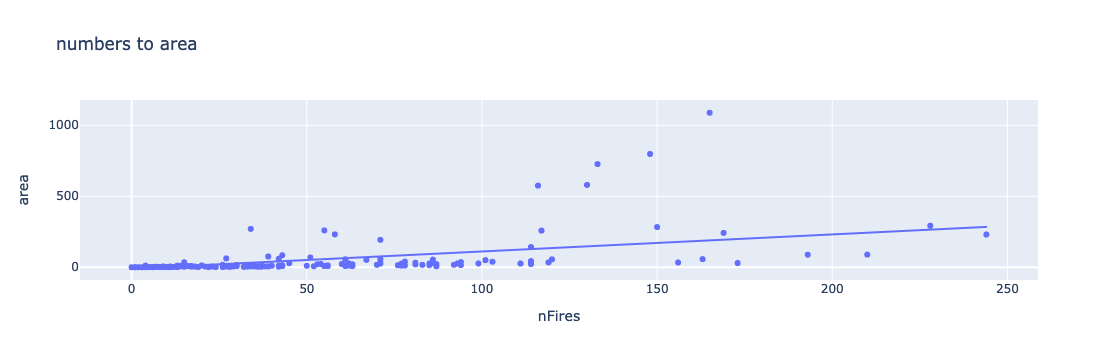

In [81]:
fig1 = pl.scatter(merged, x = "nFires", y = 'area', trendline="ols", title='numbers to area')
fig1.show()

In [151]:
merged['area'].values

array([0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0], dtype=object)

In [276]:
from sklearn.preprocessing import normalize

normalize(merged[['pr', 'sfcWind', 'tasmax']])
normalize(future_bb_weather[['pr', 'sfcWind', 'tasmax']])

array([[0.18212829, 0.01730162, 0.98312255],
       [0.19302808, 0.01677912, 0.98104976],
       [0.22406128, 0.01549108, 0.97445193],
       ...,
       [0.18655228, 0.01908369, 0.98225967],
       [0.16395978, 0.01880305, 0.98628781],
       [0.17070197, 0.01887012, 0.985142  ]])

In [265]:
'''
Achtung hier lineare korrelationen -> hoch heißt korrelation ist stark aber niedrig kann andere art von korrelation sein
(BSP regen zu feuer)
'''
#sb.heatmap(nr.corr(), annot=True)
sb.heatmap(merged.corr(), annot=True)

/var/folders/49/zy67n0_s5092yj0y7f72hb1h0000gn/T/ipykernel_8450/1597692437.py:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

In [266]:
str_parameter_list = [str(param) for param in parameter_list]
dates = merged[['Year', 'Month']]
feature_list = ["sfcWind", "pr", "tasmax"]
X = merged[feature_list]
y_nr = merged["nFires"]
y_area = merged['area']
#X, y, dates = shuffle(X, y, dates, random_state=42)
X_train_nr, X_test_nr, y_train_nr, y_test_nr, dates_train, dates_test = train_test_split(X, y_nr, dates, test_size=0.2, random_state=42)
X_train_area, X_test_area, y_train_area, y_test_area, dates_train, dates_test = train_test_split(X, y_area, dates, test_size=0.2, random_state=42)

In [267]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {
    "n_estimators": [60, 70, 80],
    "max_depth": [3, 5, 6],  # Smaller range for max depth
    "min_samples_leaf": [2, 3, 5],
    "min_samples_split": [5, 7, 8]
}
gbr = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=gbr, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)
#searching for the right parameters using random Forest on a 5-fold Cross Validation (cv) and the nmse
nr_grid = grid_search.fit(X_train_nr, y_train_nr)

# saving best parameters and model
nr_best_params = grid_search.best_params_
nr_best_model = grid_search.best_estimator_
print(nr_best_params)
print(nr_best_model)

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 70}
GradientBoostingRegressor(max_depth=5, min_samples_leaf=3, min_samples_split=7,
                          n_estimators=70)


In [268]:
param_grid = {
    "n_estimators": [75, 80, 90, 120],
    "max_depth": [5, 6, 8, 10],  # Smaller range for max depth
    "min_samples_leaf": [2, 3, 4],
    "min_samples_split": [6, 7, 8]
}
gbr = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=gbr, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)
#searching for the right parameters using random Forest on a 5-fold Cross Validation (cv) and the nmse
area_grid = grid_search.fit(X_train_area, y_train_area)

# saving best parameters and model
area_best_params = grid_search.best_params_
area_best_model = grid_search.best_estimator_
print(area_best_params)
print(area_best_model)

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 75}
GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=7,
                          n_estimators=75)


In [269]:
y_pred_area = area_best_model.predict(X_test_area)


mse = mean_squared_error(y_test_area, y_pred_area)
r2 = r2_score(y_test_area, y_pred_area)
mae = mean_absolute_error(y_test_area, y_pred_area)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")

MSE: 5346.251356115478
R2 Score: 0.23464001202438656
MAE: 23.68191353132663


In [270]:
#predict 'Anzahl Waldbrände' with the model
y_pred_nr = nr_best_model.predict(X_test_nr)


mse = mean_squared_error(y_test_nr, y_pred_nr)
r2 = r2_score(y_test_nr, y_pred_nr)
mae = mean_absolute_error(y_test_nr, y_pred_nr)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")

MSE: 762.8942756950903
R2 Score: 0.5883784271503567
MAE: 15.587253565374


In [271]:
me.evaluate_models(X_train_nr, X_test_nr, y_train_nr, y_test_nr)

{'Linear Regression': {'model': LinearRegression(),
  'mse': 1045.7107117803712,
  'r2_score': 0.4357840900869582},
 'Ridge Regression': {'model': Ridge(),
  'mse': 1045.7106154731719,
  'r2_score': 0.4357841420497558},
 'Lasso Regression': {'model': Lasso(),
  'mse': 1045.9761383906352,
  'r2_score': 0.4356408784752397},
 'Decision Tree Regression': {'model': DecisionTreeRegressor(),
  'mse': 1422.2331768388106,
  'r2_score': 0.23263042355909025},
 'Random Forest Regression': {'model': RandomForestRegressor(),
  'mse': 803.9341743348983,
  'r2_score': 0.5662352440568459},
 'Support Vector Regression': {'model': SVR(),
  'mse': 1782.4880178659375,
  'r2_score': 0.038253995507935845},
 'Gradient Boosting Regression': {'model': GradientBoostingRegressor(),
  'mse': 783.267859579869,
  'r2_score': 0.5773858074513873}}

In [272]:
me.evaluate_models(X_train_area, X_test_area, y_train_area, y_test_area)

{'Linear Regression': {'model': LinearRegression(),
  'mse': 6131.901750491532,
  'r2_score': 0.12216767648691329},
 'Ridge Regression': {'model': Ridge(),
  'mse': 6131.897396539058,
  'r2_score': 0.12216829979112986},
 'Lasso Regression': {'model': Lasso(),
  'mse': 6127.252970747976,
  'r2_score': 0.12283318765943962},
 'Decision Tree Regression': {'model': DecisionTreeRegressor(),
  'mse': 10360.637759154928,
  'r2_score': -0.4832107700465593},
 'Random Forest Regression': {'model': RandomForestRegressor(),
  'mse': 5430.418454868365,
  'r2_score': 0.22259079746290433},
 'Support Vector Regression': {'model': SVR(),
  'mse': 7182.956464984858,
  'r2_score': -0.028299477049769095},
 'Gradient Boosting Regression': {'model': GradientBoostingRegressor(),
  'mse': 5650.06219277097,
  'r2_score': 0.19114698433059374}}

In [273]:
nr_predictions = nr_best_model.predict(future_bb_weather[feature_list])
area_predictions = area_best_model.predict(future_bb_weather[feature_list])
final_predictions = pd.DataFrame({'Year': future_bb_weather['Year'], 'Month': future_bb_weather['Month'], 'tasmax': future_bb_weather['tasmax'], 'sfcWind': future_bb_weather['sfcWind'],'pr': future_bb_weather['pr'], 'area_predictions': area_predictions, 'nr_predictions': nr_predictions})

In [274]:
final_predictions

Year  Month     tasmax   sfcWind         pr  area_predictions  \
0      2024      1  278.43063  4.900000  51.580644          0.747156   
1      2024      1  278.38547  4.761291  54.774196          0.300916   
2      2024      1  278.19840  4.422581  63.967742          0.300916   
3      2024      1  278.55966  4.416129  47.709679          0.747156   
4      2024      1  278.54030  4.367742  47.709679          0.747156   
...     ...    ...        ...       ...        ...               ...   
70390  2054      1  274.10160  4.516129  41.612901          0.902444   
70391  2054      1  273.57257  5.196774  51.967742          0.747156   
70392  2054      1  273.62740  5.316129  51.967742          0.747156   
70393  2054      1  273.60483  5.216129  45.483872          0.747156   
70394  2054      1  273.66290  5.241936  47.419354          0.747156   

       nr_predictions  
0            0.494405  
1            0.494405  
2            0.494405  
3            0.494405  
4            0.494405  
...               ...  
70390        0.711383  
70391        0.494405  
70392        0.494405  
70393        0.711383  
70394        0.494405  

[70395 rows x 7 columns]

In [128]:
final_predictions.to_csv(common_paths.DATA.joinpath("dwd/final_predictions.csv"))

In [277]:
final_predictions[['nr_predictions', 'area_predictions']].describe()

nr_predictions  area_predictions
count    70395.000000      70395.000000
mean         6.585629          3.826320
std         10.577021          5.833296
min         -2.876504        -19.752522
25%          0.711383          0.747156
50%          1.813418          2.113748
75%          8.928104          4.927920
max        198.284173         83.421740

In [278]:
merged.nFires
#merged.nFires.describe()

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6385    0.0
6386    0.0
6387    0.0
6388    0.0
6389    0.0
Name: nFires, Length: 6390, dtype: float64

In [279]:
merged.area
#merged.area.describe()

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6385    0.0
6386    0.0
6387    0.0
6388    0.0
6389    0.0
Name: area, Length: 6390, dtype: object